# *Deep k-Means: Jointly clustering with k-Means and learning representations*
## Lívia Cereja Meinhardt

Neste *assignment* foi implementado o Deep k-means ([DKM](https://arxiv.org/pdf/1806.10069.pdf)). A suposição deste método é que aprender as representações e os clusteres de forma conjunta pode levar a uma melhor performance de clusterização.

Neste relatório serão apresentados os resultados de duas variantes deste método, para várias configurações do parâmetro $\alpha$, discutidas a seguir.

## Variantes do Deep k-means

### Annealing

Nesta variante,  $\alpha$ evolui seguindo a sequência:

$\alpha_{n+1}= 2^{1/log(n)^2} ×\alpha_n$ with $m_\alpha = \alpha_1= 0.1$

Esta configuração faz com que mais iterações tenham alphas menores, enquanto menos iterações tenham alpha grande, ou seja, o modelo passa menos tempo fazendo *hard assigment*. Vamos entender o impacto desta escolha nos testes. 

### Pretrained

Nesta outra variante do Deep k-mean, utilizamos um alpha constante durante o treinamento do modelo. Iremos comparar as duas abordagens a seguir.


In [1]:
!pip install scikit-learn==0.22.2 --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.0 MB 20.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.22.2 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.22.2 which is incompatible.


In [2]:
# Alpha Schemes
import numpy as np
import matplotlib.pyplot as plt
import sys

def show_alfas():
  plt.figure(figsize=(16,5))

  alpha_1 = 0.01 # Used to modify the range of the alpha scheme
  alpha_2 = 0.1 
  alpha_3 = 0.5
  alpha_4 = 1

  scheme_1 = [alpha_1]

    
    # gammas_5[i] = np.array([((i / max_n) ** alpha_5)])

  plt.subplot(1,3,3)
  plt.plot(np.arange(max_n),gammas_1, label = r'$\alpha_n$ = 0.01')
  plt.plot(np.arange(max_n),gammas_2, label = r'$\alpha_n$ = 0.1')
  plt.plot(np.arange(max_n),gammas_3, label = r'$\alpha_n$ = 0.5')
  plt.plot(np.arange(max_n),gammas_4, label = r'$\alpha_n$ = 1')
  # plt.plot(np.arange(max_n),gammas_5, label = r'$\alpha_n$ = 4')

  plt.xlabel('n',fontsize = 16); plt.ylabel(r'$\gamma_n$',fontsize = 16);
  plt.legend()


## **Código**

Começamos importando as bibliotecas necessárias:

In [3]:
import tensorflow as tf
import pandas as pd
from tensorflow.compat.v1 import keras
import argparse
import seaborn as sns
import numpy as np
from tensorflow.compat.v1.keras.layers import Dense
from tensorflow.compat.v1.keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.compat.v1.keras.optimizers import Adam, SGD
from tensorflow.compat.v1.keras.models import Model
from tensorflow.compat.v1.keras.layers import Input
from sklearn.cluster import KMeans
!pip install visualkeras
import visualkeras
from tensorflow.compat.v1.keras.layers import Layer
from tensorflow.keras.layers import InputSpec
from tensorflow.compat.v1.keras import backend as K
import sklearn.metrics as metrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 992 kB 33.1 MB/s 


###**Dados**

Utilizaremos o dataset MNIST, que contém 70.000 imagens (28x28), de 10 classes distintas (digitos escritos a mâo). Uma amostra desses dados é apresentada abaixo:


11490434/11490434 [==============================] - 0s 0us/step


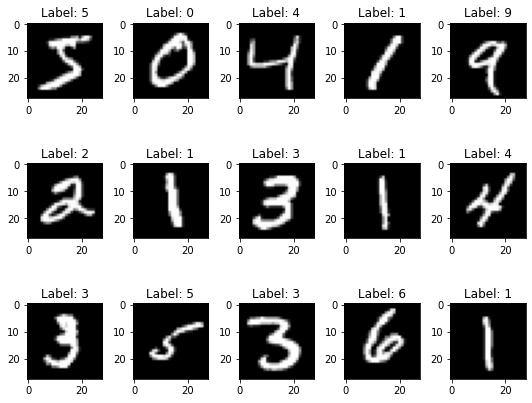

In [4]:
def load_mnist():

    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist
               
    (x_train, y_train), (x_test, y_test) = mnist.load_data()  
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    
    # reshape x to (70000, 28*28)    
    x = x.reshape((x.shape[0], -1))
    x = np.divide(x, 255.) 
    # print('MNIST samples', x.shape)

    num = 15
    images = x_train[:num]
    labels = y_train[:num]
    num_row = 3
    num_col = 5
    
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title('Label: {}'.format(labels[i]))
    plt.tight_layout()
    plt.show()

    return x, y

x, y = load_mnist()

###**Modelo**

Começamos definindo todas as funções necessárias (fornecidas previamente):

In [5]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, labels = None, batch_size = 64, dim = 28, n_classes=10,
                 samp_per_epoch = None, shuffle=False, flag_AE = False):
        '''
        Parameters
        ----------
        data : image stack with shape (row, col, channels*seq)
        labels : labels stack with shape (row, col, seq)
        coords : x,y coordinate for each pixel of interest
        idx_coord : index of coordinates, shape (len(coords),2)
        channels : channels of imput data for each seq. The default is 14.
        patch_size : patch size. The default is 15.
        batch_size : The default is 32.
        dim : input dimension for the CNN model. The default is (15,15,14).
        n_classes : number of classes. The default is 4.
        samp_per_epoch : (optional) # of samples for each epoch. The default is None.
        shuffle : (optional) shuffle after each epoch. The default is False.
        use_augm : (optional) data augmenattion. The default is False.

        Returns
        -------
            Datagenerator

        '''
        self.data = data
        self.label = labels
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_classes = n_classes
        self.samp_per_epoch = samp_per_epoch
        self.flag_AE = flag_AE
        self.list_IDs = np.arange(len(self.data))
        
        self.on_epoch_end()
  
    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.samp_per_epoch:  
            # train over #samp_per_epoch random samples at each epoch
            return int(np.ceil(self.samp_per_epoch / self.batch_size))
        else:
            # use all avaliable samples at each epoch
            return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        if (index+1)*self.batch_size > len(self.indexes):
            indexes = self.indexes[index*self.batch_size:]
        else:
            indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]        
        # Find list of IDs
        idx_tmp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, Y = self.__data_generation(idx_tmp)
        
        return X, Y 

    def on_epoch_end(self):
        'Updates indexes and list coords after each epoch'
        if self.samp_per_epoch:
            self.indexes = np.arange(self.samp_per_epoch)
        else:
            self.indexes = np.arange(len(self.list_IDs))
            
        if self.shuffle == True:
            # shuffle indexes we use to iterate on
            np.random.shuffle(self.indexes)

    def __data_generation(self, idx_tmp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim)
        # Initialization
        X = np.empty((len(idx_tmp), self.dim*self.dim))

        X = self.data[idx_tmp]
                
        if self.flag_AE:
            return X, X
            
            
        return X, [X, np.ones((len(idx_tmp)))]

In [6]:
def autoencoder_(dims, act='relu'):
        """
        Fully connected auto-encoder model, symmetric. 
        Arguments:
            dims: list of number of units in each layer d-500-500-2000-K, 
                  where d is the original data space dimension and K is the number 
                  of clusters to obtain.
                  The decoder is symmetric with encoder. 
        return:
            Model of autoencoder
        """
        n_stacks = len(dims) - 1
        # input
        x = Input(shape=(dims[0],), name='input')
        h = x
    
        # internal layers in encoder
        for i in range(n_stacks-1):
            h = Dense(dims[i + 1], activation=act, name='encoder_%d' % i)(h)
    
        # hidden layer
        encoder_layer = Dense(dims[-1], name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here
    
        # internal layers in decoder
        for i in range(n_stacks-1, 0, -1):
            if i == n_stacks-1:
                h = encoder_layer
            h = Dense(dims[i], activation=act, name='decoder_%d' % i)(h)
    
        # output
        h = Dense(dims[0], name='AE_')(h)
        
        encoder = Model(inputs=x, outputs=encoder_layer)
        autoencoder = Model(inputs=x, outputs=h)
        
        return autoencoder,encoder       

In [7]:
# Reconstruction Loss
def g_func(x, x_):
   return tf.reduce_sum(tf.square(x - x_), axis=1)

def Loss_AE():
    """The AE network is trained by minimizing the reconstruction error, 
    L(x,x^), which measures the differences between our original input and 
    the consequent reconstruction. """
    def loss(y_true, y_pred):
        rec_error = g_func(y_true, y_pred)
        ae_loss = tf.reduce_mean(rec_error)
        return ae_loss
    return loss

In [8]:
def f_func(h, rk):
   return tf.reduce_sum(tf.square(h - rk), axis=1)

class DistanceLayer(Layer):
    """ Layer which calculates the distance from each point to all centroids"""

    def __init__(self, n_clusters, weights=None, alpha = 1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(DistanceLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        initializer = tf.keras.initializers.RandomUniform(minval=-1, maxval=1)
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer= initializer, name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        ## Compute the distance f between the embedding and each cluster representative
        list_dist = []
        for i in range(0, self.n_clusters):
            dist = f_func(inputs, self.clusters[i:i+1, :])
            list_dist.append(dist)
        self.stack_dist = tf.stack(list_dist)
       
        return tf.transpose(self.stack_dist)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(DistanceLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
     

In [9]:
class  Softmax_function(Layer):
    """ Layer which calculates the softmax function from the distance 
    of the samples to the centroids"""

    def __init__(self, n_clusters, weights=None, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Softmax_function, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)


    def build(self, input_shape):
        assert len(input_shape) == 2
        #input_dim = input_shape[1]
        #self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.alpha = self.add_weight(shape=(1,), initializer='glorot_uniform', name='alpha')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True


    def call(self, dists, **kwargs):
        
        dists = tf.transpose(dists)
        # Second, find the minimum squared distance for softmax normalization
        min_dist = tf.reduce_min(dists, axis=0)           
        # Third, compute exponentials shifted with min_dist to avoid underflow (0/0) issues in softmaxes
        list_exp = []
        for i in range(self.n_clusters):
            exp = tf.exp(-self.alpha * (dists[i] - min_dist))
            list_exp.append(exp)
        stack_exp = tf.stack(list_exp)
        sum_exponentials = tf.reduce_sum(stack_exp, axis=0)       
        # print(sum_exponentials.get_shape().as_list())
        #Compute softmaxes and the embedding/representative distances weighted by softmax
        list_softmax = []
        list_weighted_dist = []
        for j in range(self.n_clusters):
            softmax = stack_exp[j] / sum_exponentials
            weighted_dist = dists[j] * softmax
            list_softmax.append(softmax)
            list_weighted_dist.append(weighted_dist)
        stack_weighted_dist = tf.stack(list_weighted_dist)
        
        stack_weighted_dist = tf.transpose(stack_weighted_dist)
        return stack_weighted_dist
    
    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0],

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(Softmax_function, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def Loss_Clustering(lambda_):

    def loss(y_true, y_pred):
        return tf.reduce_mean(tf.reduce_sum(tf.transpose(y_pred), axis=0)) * lambda_
    
    return loss
    

In [10]:
def assigment_cluster(y_true, y_pred):

    w = np.zeros((20, 20), dtype=np.int64)

    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    
    """Solve the linear assignment problem using the Hungarian algorithm
    https://www.hungarianalgorithm.com/examplehungarianalgorithm.php"""
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)

    aux = np.zeros_like(y_pred)
    for i in range(len(ind)):        
        aux[y_pred==ind[i,0]] = ind[i,1]
    y_pred = aux

    return y_pred

## **Testes**

Primeiro, iremos comparar as duas variações do Deep k-means para diversas configurações de alpha, como comentado. 

In [32]:
def run(x, y, Pre_train = False, alpha_zero=0.1,   num_epochs_AE = 50,   lambda_ = 1, constant_alpha=1000,n_clusters = 10,preds=False):

  if Pre_train:  Annealing = False
  else:  Annealing = True

  optimizer= Adam(learning_rate=1e-3)  
  
  #Alpha Parameter
  if Annealing and not Pre_train:
      
      constant_value = 1  # Used to modify the range of the alpha scheme
      max_n = 40  # Number of alpha values to consider
      alphas = np.zeros(max_n, dtype=float)
      alphas[0] = 0.1
      for i in range(1, max_n):
          alphas[i] = (2 ** (1 / (np.log(i + 1)) ** 2)) * alphas[i - 1]
      alphas = alphas / constant_value
      print("Annealing Scheme Done!")

  elif not Annealing and Pre_train:
      constant_value = 1  # Used to modify the range of the alpha scheme
      max_n = 20  # Number of alpha values to consider
      alpha = 1000
      alphas = alpha*np.ones(max_n, dtype=float) # alpha is constant
      alphas = alphas / constant_value
      print("Pre-train Scheme Done!")
  else:
      parser.error("Run with either annealing or pretraining, but not both for DKM.")
      exit()

  plt.figure(figsize=(5,5))
  plt.plot(np.arange(max_n),alphas)
  plt.xlabel('n',fontsize = 16); plt.ylabel(r'$\alpha_n$',fontsize = 16);

  #Autoencoder
  dims = [x.shape[-1], 500, 500, 2000, 10]
  n_stacks = len(dims) - 1
  autoencoder,encoder = autoencoder_(dims)
  autoencoder.summary()

    # PRE TRAINED
  if Pre_train:
      
      # Step 1: pretrain the autoencoder

      autoencoder.compile(optimizer=optimizer, loss=Loss_AE())
      
      training_generator = DataGenerator(x, labels = None, batch_size = 256, dim = dims[0], n_classes=10,
                              samp_per_epoch = None, shuffle=True, flag_AE = True)
      
      # Train model on dataset
      history = autoencoder.fit_generator(generator=training_generator, epochs = num_epochs_AE)

      # Step 2: initialize cluster centers using k-means    
          
      print('Initializing cluster centers with k-means')      
      # n_init : Number of time the k-means algorithm will be run with different centroid seeds.
      kmeans = KMeans(n_clusters= n_clusters, init="k-means++")

      AE_generator = DataGenerator(x, labels = None, batch_size = 256, dim = dims[0], n_classes=10,
                                              samp_per_epoch = None, shuffle=False, flag_AE = True)
                        
      print('Extract Features')
      extract_features = encoder.predict_generator(AE_generator, verbose=1)
              
      y_pred = kmeans.fit_predict(extract_features)


  # DEEP NETWORK
  hidden = autoencoder.get_layer(name='encoder_%d' % (n_stacks - 1)).output
  encoder = Model(inputs=autoencoder.input, outputs=hidden)
  distance_layer = DistanceLayer(n_clusters= n_clusters, name='distance')(hidden)
  softmax_function = Softmax_function(n_clusters, trainable=False, name='clustering')(distance_layer)      
  Deep_km = Model(inputs=encoder.input, outputs=[autoencoder.output, softmax_function]) 
  model_see = Model(inputs=encoder.input, outputs= softmax_function)
  model_see.summary() 

  # TRAIN

  Deep_km.compile(optimizer=optimizer, loss=[Loss_AE(), Loss_Clustering(lambda_)])
  if Pre_train:
      Deep_km.get_layer(name='distance').set_weights([kmeans.cluster_centers_])

  deep_kmeans_gen = DataGenerator(x, labels = None, batch_size = 256, dim = dims[0], n_classes=10,samp_per_epoch = None, shuffle=True)
  num_epochs_per_alpha = 1
  for k in range(len(alphas)):
      
      print("Training step: alpha[{}]: {}".format(k, alphas[k]))                
      Deep_km.get_layer(name='clustering').set_weights([alphas[k:k+1]])
      print(Deep_km.get_layer(name='clustering').get_weights()[0].reshape((-1))[0])
      history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs = num_epochs_per_alpha)

  Deep_km_predictor = Model(inputs=Deep_km.input, outputs= distance_layer)               
  AE_generator =  DataGenerator(x, None, batch_size = 256, dim = dims[0], n_classes=10, shuffle=False)
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)
  y_pred = np.argmin(extract_feat, axis = 1)


  #EVALUATION METRICS
  y_pred_map = assigment_cluster(y, y_pred) 

  acc =  np.round(metrics.accuracy_score(y, y_pred_map),5)
  nmi = np.round(metrics.normalized_mutual_info_score(y, y_pred_map), 5)
  f1score = 100*metrics.f1_score(y, y_pred_map, average = None)

  if not preds:
    try:
      # F1 score Bars
      x = np.arange(10)  # the label locations
      width = 0.35  # the width of the bars
      fig, ax = plt.subplots()
      rects1 = ax.bar(x, f1score, width, label='Digits')
      # Add some text for labels, title and custom x-axis tick labels, etc.
      ax.set_ylabel('Scores', fontsize=15)
      ax.set_xlabel('Digits', fontsize=15)
      ax.set_title('F1 score per class', fontsize=15)
      ax.set_xticks(x)
      fig.tight_layout()
      plt.show()
    except: print('Error plotting 1 scores bars')
    
    # Heatmap
    classes = np.unique(y)
    cm = metrics.confusion_matrix(y, y_pred_map, labels =classes)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.round(cm,decimals=2 )
    plt.figure(figsize=(12, 12))
    sns.heatmap(cm, annot=True, cbar=0, cmap="YlGnBu", linewidths=.5, linecolor= 'black')
    plt.title('Accuracy: ' + str(np.round(acc,decimals=2 )), fontsize=20)
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Pred label', fontsize=20)
    plt.show()# Heatmap
    
    return acc, f1score, cm
  else:
    return y_pred_map

Annealing Scheme Done!
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 8s 16ms/step - loss: 35.0545 - AE__loss: 32.6126 - clustering_loss: 2.4419
Training step: alpha[1]: 0.42320861065570825
0.42320862
274/274 [==============================] - 6s 21ms/step - loss: 20.1613 - AE__loss: 19.0540 - clustering_loss: 1.1073
Training step: alpha[2]: 0.7515684111296623
0.75156844
274/274 [==============================] - 5s 20ms/step - loss: 17.2267 - AE__loss: 16.6513 - clustering_loss: 0.5754
Training step: alpha[3]: 1.077971160195895
1.0779711
274/274 [==============================] - 6s 20ms/step - loss: 15.7121 - AE__loss: 15.3644 - clustering_loss: 0.3476
Training step: alpha[4]: 1.4087110115785935
1.408711
274/274 [==============================] - 3s 11ms/step - loss: 14.7359 - AE__loss: 14.4932 - clustering_loss: 0.2427
Training step: alpha[5]: 1.7481914085889256
1.7481914
274/274 [==============================] - 3s 12ms/step - loss: 14.0488 - AE__loss: 13.8501 - clustering_loss: 0.1987
Training step: alpha[

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


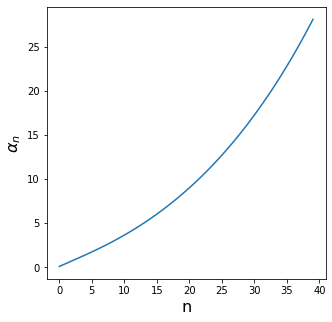

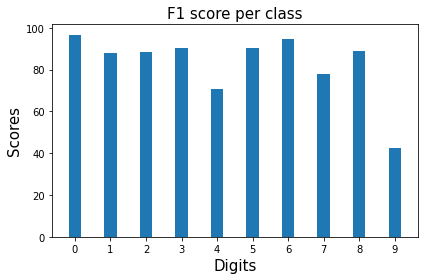

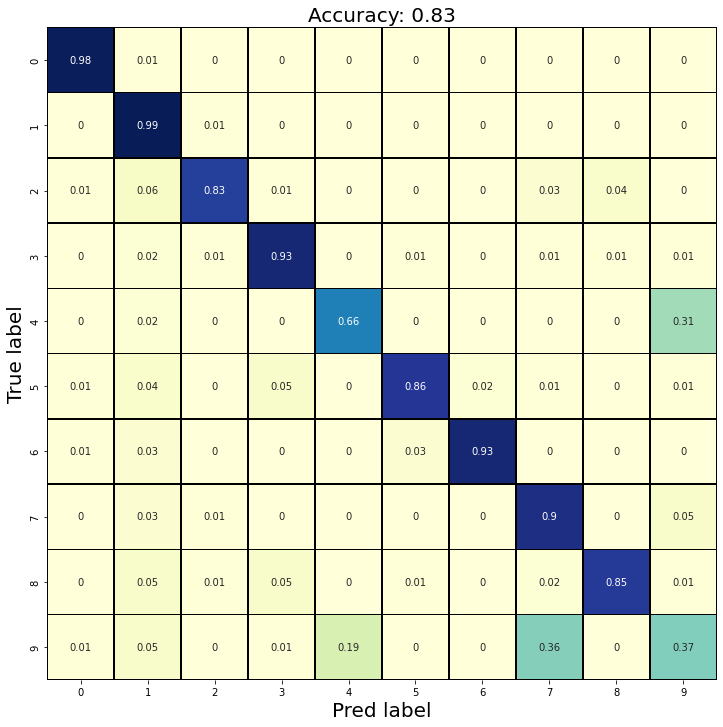

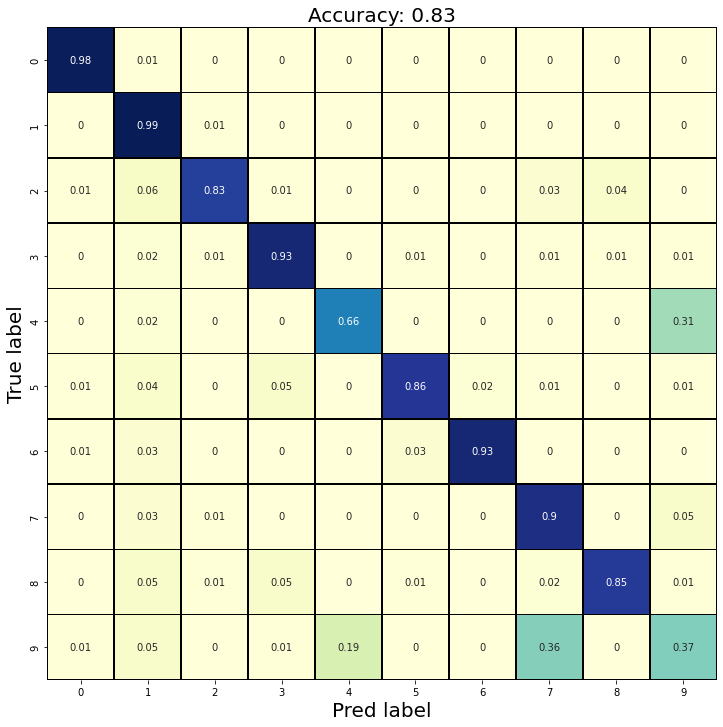

Annealing Scheme Done!
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 6s 11ms/step - loss: 37.2094 - AE__loss: 35.1760 - clustering_loss: 2.0334
Training step: alpha[1]: 0.42320861065570825
0.42320862
274/274 [==============================] - 3s 12ms/step - loss: 20.3838 - AE__loss: 19.4783 - clustering_loss: 0.9054
Training step: alpha[2]: 0.7515684111296623
0.75156844
274/274 [==============================] - 4s 15ms/step - loss: 17.4358 - AE__loss: 16.9391 - clustering_loss: 0.4966
Training step: alpha[3]: 1.077971160195895
1.0779711
274/274 [==============================] - 3s 12ms/step - loss: 15.9239 - AE__loss: 15.5914 - clustering_loss: 0.3325
Training step: alpha[4]: 1.4087110115785935
1.408711
274/274 [==============================] - 3s 11ms/step - loss: 14.9467 - AE__loss: 14.7008 - clustering_loss: 0.2460
Training step: alpha[5]: 1.7481914085889256
1.7481914
274/274 [==============================] - 3s 11ms/step - loss: 14.1761 - AE__loss: 13.9739 - clustering_loss: 0.2023
Training step: alpha[

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


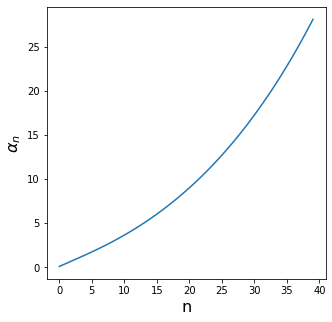

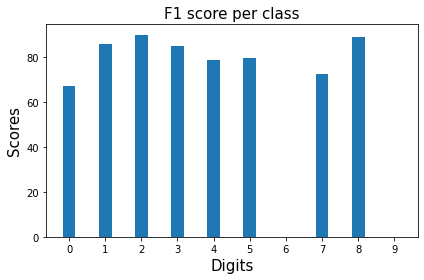

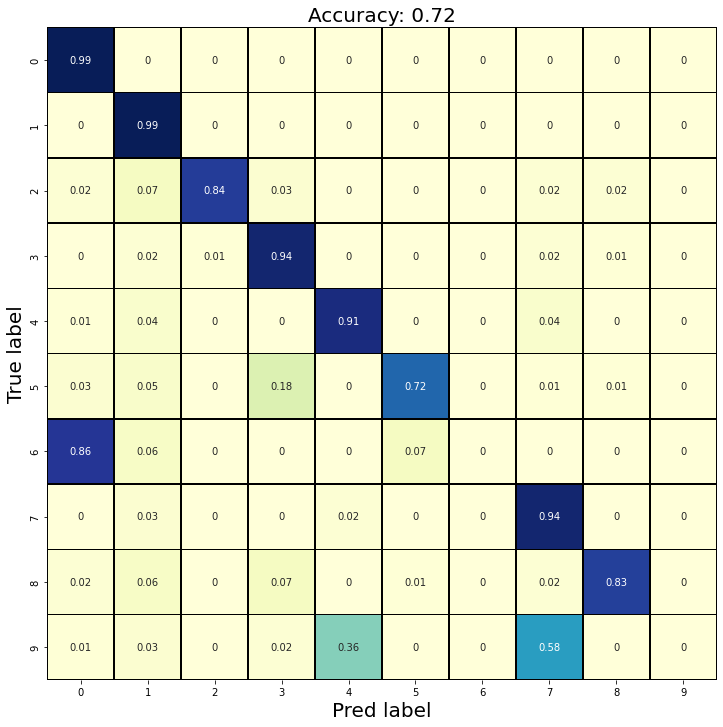

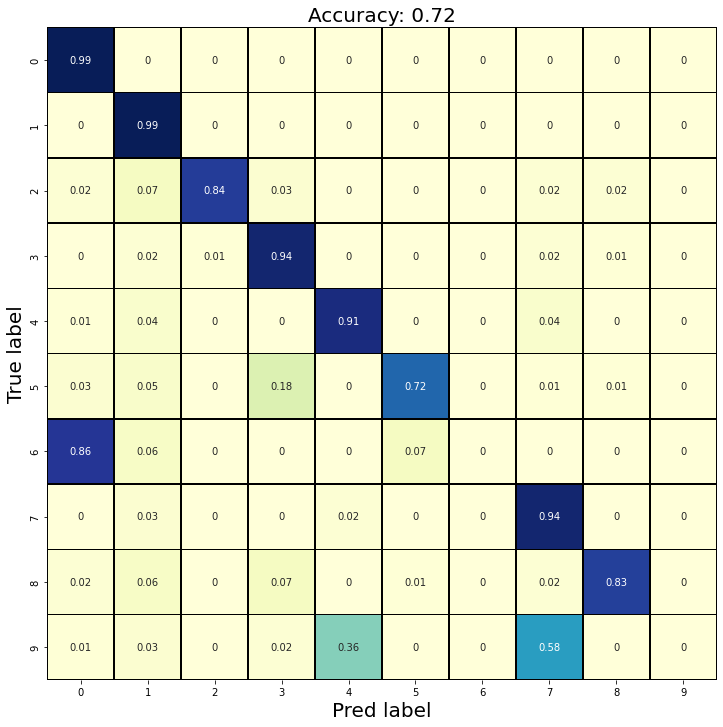

Annealing Scheme Done!
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 6s 12ms/step - loss: 38.2842 - AE__loss: 36.1519 - clustering_loss: 2.1323
Training step: alpha[1]: 0.42320861065570825
0.42320862
274/274 [==============================] - 3s 12ms/step - loss: 20.7674 - AE__loss: 19.7666 - clustering_loss: 1.0009
Training step: alpha[2]: 0.7515684111296623
0.75156844
274/274 [==============================] - 3s 12ms/step - loss: 17.6675 - AE__loss: 17.1255 - clustering_loss: 0.5421
Training step: alpha[3]: 1.077971160195895
1.0779711
274/274 [==============================] - 3s 12ms/step - loss: 16.0473 - AE__loss: 15.7090 - clustering_loss: 0.3383
Training step: alpha[4]: 1.4087110115785935
1.408711
274/274 [==============================] - 3s 12ms/step - loss: 15.0076 - AE__loss: 14.7619 - clustering_loss: 0.2458
Training step: alpha[5]: 1.7481914085889256
1.7481914
274/274 [==============================] - 3s 12ms/step - loss: 14.2918 - AE__loss: 14.0860 - clustering_loss: 0.2058
Training step: alpha[

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


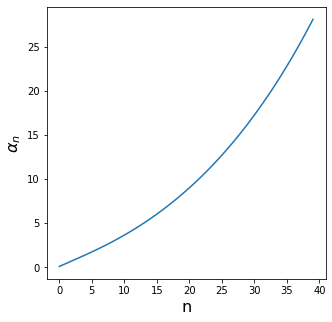

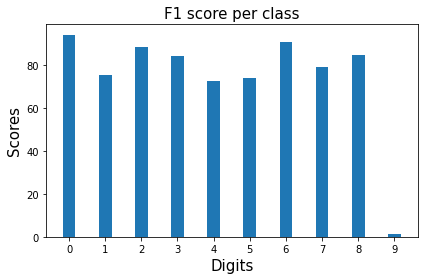

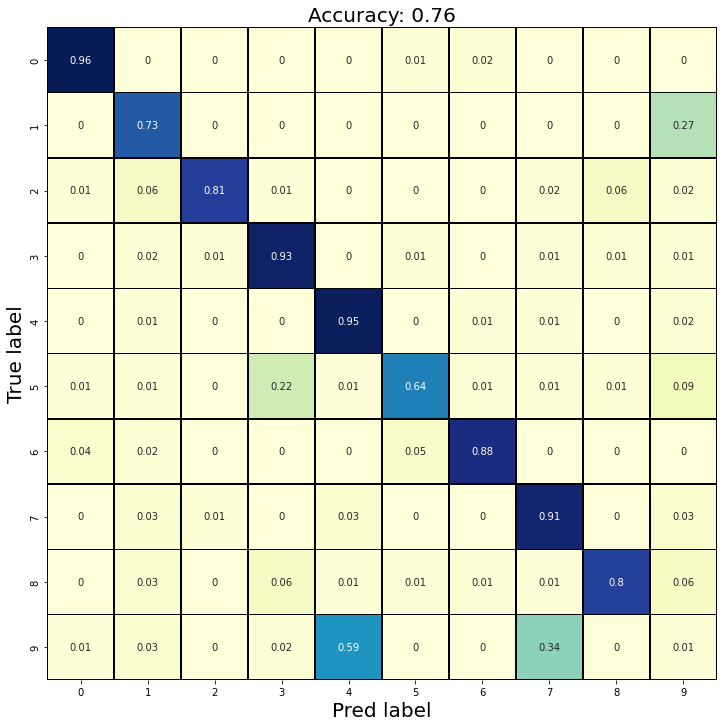

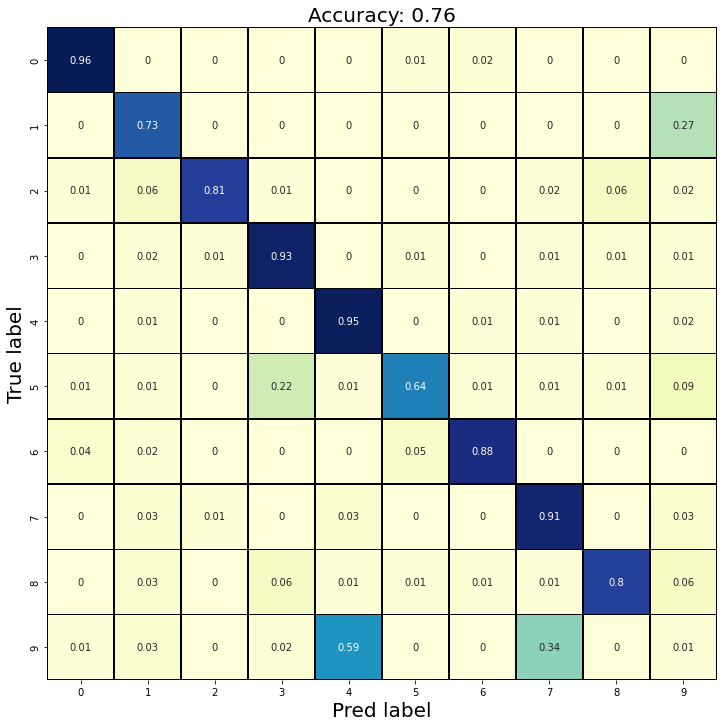

Annealing Scheme Done!
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 6s 11ms/step - loss: 35.8293 - AE__loss: 33.4093 - clustering_loss: 2.4199
Training step: alpha[1]: 0.42320861065570825
0.42320862
274/274 [==============================] - 3s 12ms/step - loss: 20.5453 - AE__loss: 19.4326 - clustering_loss: 1.1127
Training step: alpha[2]: 0.7515684111296623
0.75156844
274/274 [==============================] - 3s 12ms/step - loss: 17.5558 - AE__loss: 16.9627 - clustering_loss: 0.5932
Training step: alpha[3]: 1.077971160195895
1.0779711
274/274 [==============================] - 3s 12ms/step - loss: 15.9997 - AE__loss: 15.6228 - clustering_loss: 0.3768
Training step: alpha[4]: 1.4087110115785935
1.408711
274/274 [==============================] - 3s 12ms/step - loss: 14.9717 - AE__loss: 14.7070 - clustering_loss: 0.2646
Training step: alpha[5]: 1.7481914085889256
1.7481914
274/274 [==============================] - 3s 12ms/step - loss: 14.2348 - AE__loss: 14.0222 - clustering_loss: 0.2126
Training step: alpha[

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


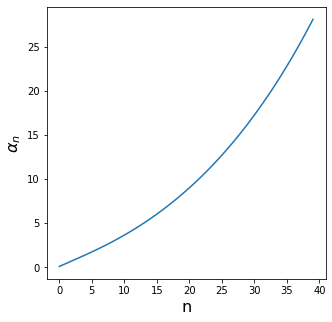

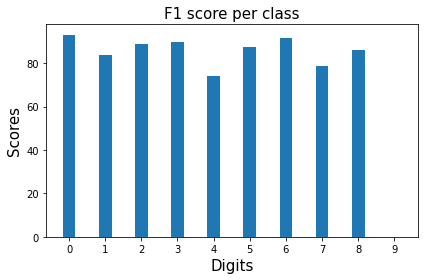

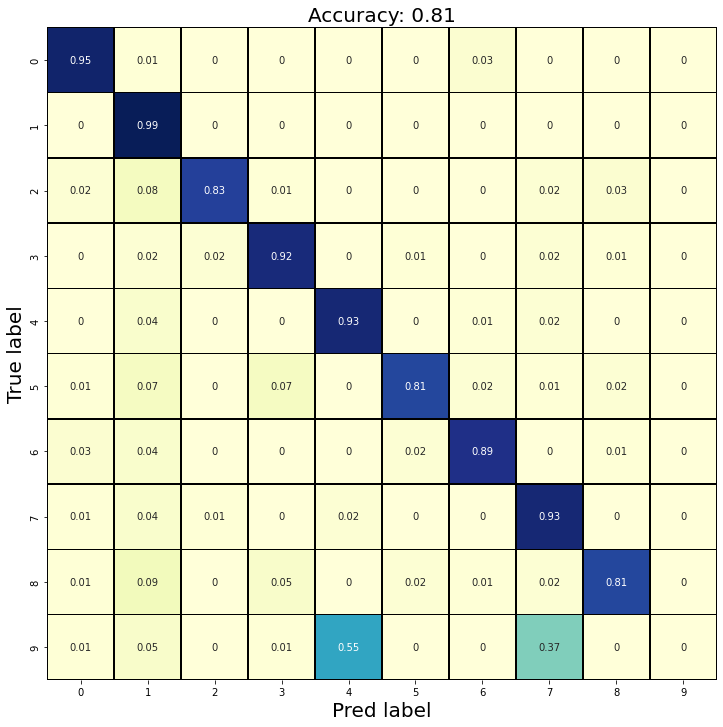

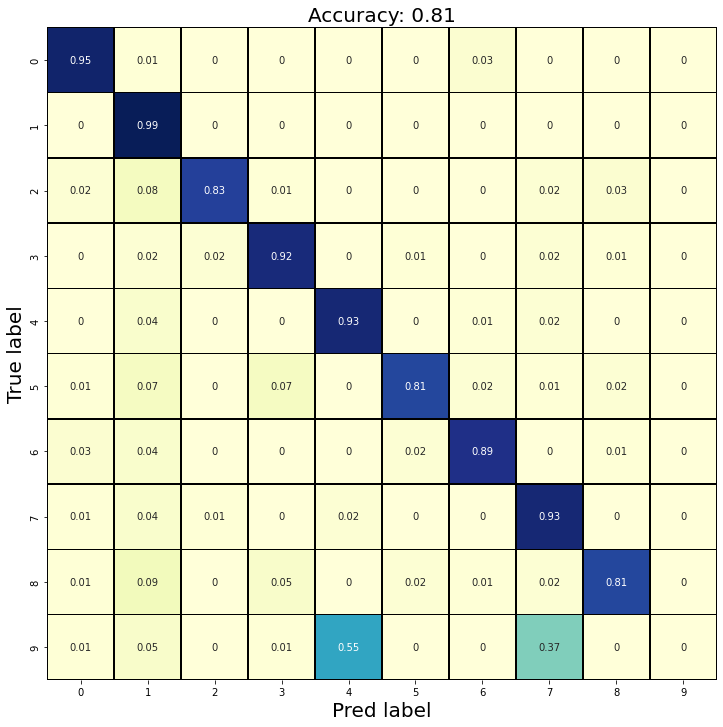

In [ ]:
#TESTE 1
import pandas as pd
results = pd.DataFrame(columns=['alpha-pretrained','alpha-annealing','accuracy','f1(1)','f1(2)','f1(3)','f1(4)','f1(5)','f1(6)','f1(7)','f1(8)','f1(9)','f1(10)'], index = range(1,9))

#Annealing 
alphas = [0.01, 0.1, 0.5, 1]
for i in range(1,5):
  acc, f1score, cm = run(x=x, y=y, Pre_train = False, alpha_zero=alphas[i-1])
  results.loc[i,:] = [0,alphas[i-1], acc] + list(f1score) 

Pre-train Scheme Done!
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 3s 7ms/step - loss: 28.3782
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 16.7444
Epoch 3/50
274/274 [==============================] - 1s 5ms/step - loss: 14.7792
Epoch 4/50
274/274 [==============================] - 2s 6ms/step - loss: 13.7104
Epoch 5/50
274/274 [==============================] - 1s 5ms/step - loss: 12.9852
Epoch 6/50
274/274 [==============================] - 2s 7ms/step - loss: 12.4119
Epoch 7/50
274/274 [==============================] - 3s 9ms/step - loss: 12.0017
Epoch 8/50
274/274 [==============================] - 3s 10ms/step - loss: 11.6131
Epoch 9/50
274/274 [==============================] - 3s 10ms/step - loss: 11.3201
Epoch 10/50
274/274 [==============================] - 3s 10ms/step - loss: 11.0543
Epoch 11/50
274/274 [==============================] - 3s 11ms/step - loss: 10.7984
Epoch 12/50
274/274 [==============================] - 3s 11ms/step - loss: 10.6099
Epoch 13/50
274/274

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 cl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 6s 11ms/step - loss: 9.9166 - AE__loss: 8.3625 - clustering_loss: 1.5540
Training step: alpha[1]: 1000.0
1000.0
274/274 [==============================] - 5s 17ms/step - loss: 9.0218 - AE__loss: 8.2117 - clustering_loss: 0.8101
Training step: alpha[2]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.6723 - AE__loss: 8.0727 - clustering_loss: 0.5996
Training step: alpha[3]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.5186 - AE__loss: 8.0335 - clustering_loss: 0.4852
Training step: alpha[4]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.3770 - AE__loss: 7.9647 - clustering_loss: 0.4123
Training step: alpha[5]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.2847 - AE__loss: 7.9255 - clustering_loss: 0.3591
Training step: alpha[6]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.2147

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


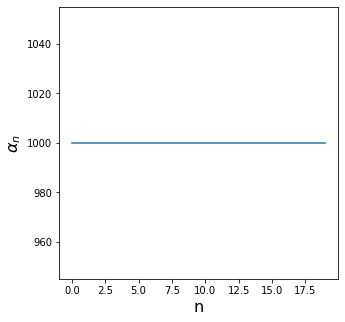

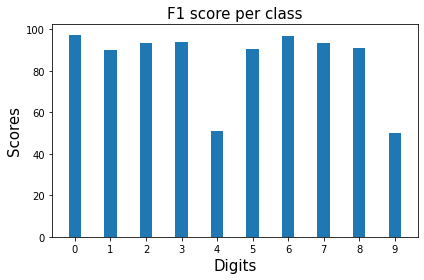

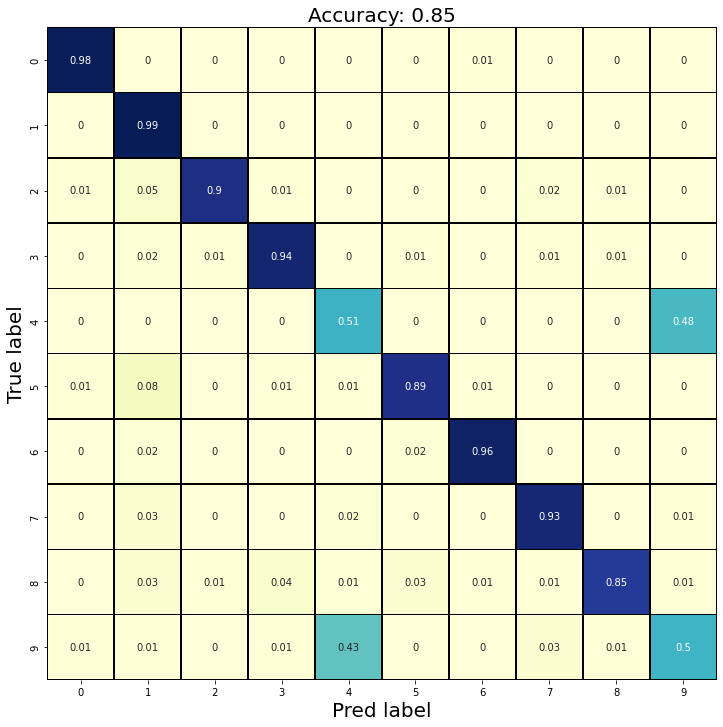

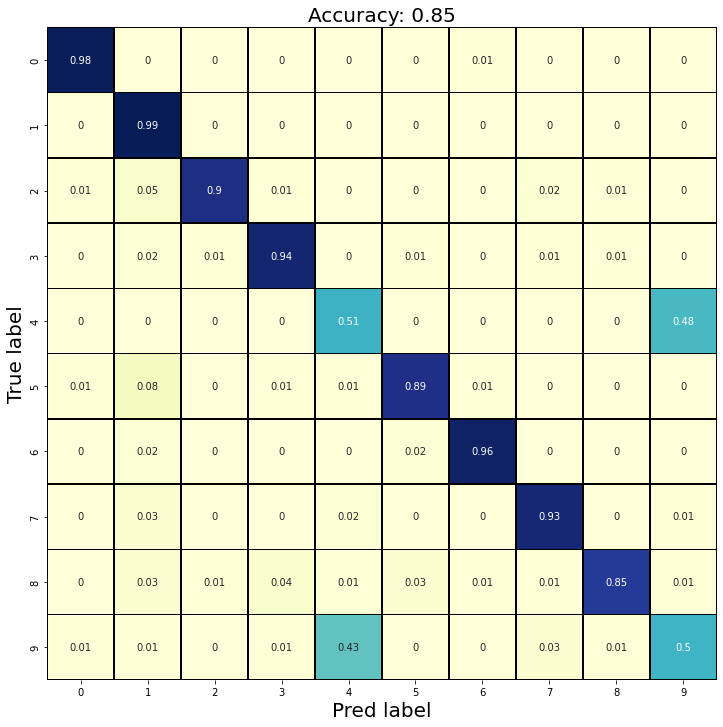

Pre-train Scheme Done!
Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 2s 6ms/step - loss: 29.2364
Epoch 2/50
274/274 [==============================] - 1s 5ms/step - loss: 17.1542
Epoch 3/50
274/274 [==============================] - 1s 5ms/step - loss: 15.0888
Epoch 4/50
274/274 [==============================] - 2s 5ms/step - loss: 13.9672
Epoch 5/50
274/274 [==============================] - 2s 5ms/step - loss: 13.1957
Epoch 6/50
274/274 [==============================] - 2s 5ms/step - loss: 12.6155
Epoch 7/50
274/274 [==============================] - 2s 5ms/step - loss: 12.1545
Epoch 8/50
274/274 [==============================] - 2s 5ms/step - loss: 11.7797
Epoch 9/50
274/274 [==============================] - 1s 5ms/step - loss: 11.4755
Epoch 10/50
274/274 [==============================] - 2s 6ms/step - loss: 11.1548
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 10.9442
Epoch 12/50
274/274 [==============================] - 1s 5ms/step - loss: 10.7010
Epoch 13/50
274/274 [===

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step
Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 cl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 6s 12ms/step - loss: 9.9303 - AE__loss: 8.3960 - clustering_loss: 1.5343
Training step: alpha[1]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 9.0419 - AE__loss: 8.2430 - clustering_loss: 0.7989
Training step: alpha[2]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.6933 - AE__loss: 8.1009 - clustering_loss: 0.5924
Training step: alpha[3]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.5176 - AE__loss: 8.0383 - clustering_loss: 0.4793
Training step: alpha[4]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.3935 - AE__loss: 7.9867 - clustering_loss: 0.4068
Training step: alpha[5]: 1000.0
1000.0
274/274 [==============================] - 3s 12ms/step - loss: 8.2948 - AE__loss: 7.9394 - clustering_loss: 0.3554
Training step: alpha[6]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.2123

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


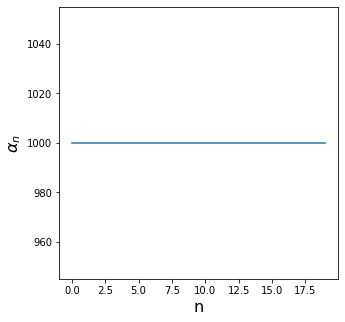

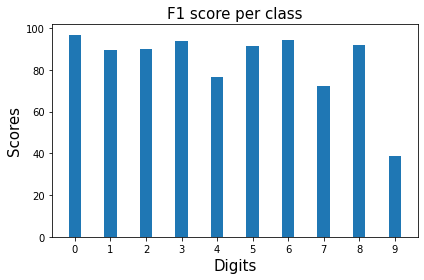

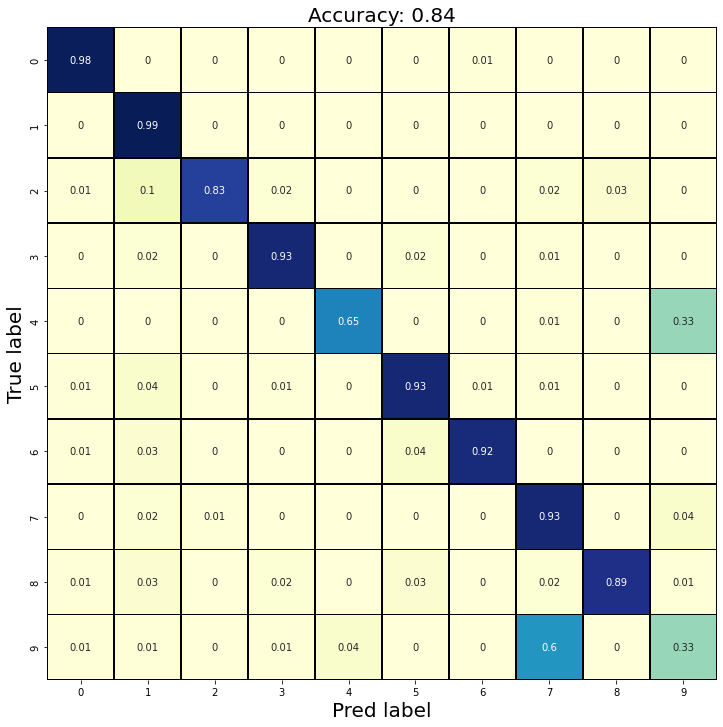

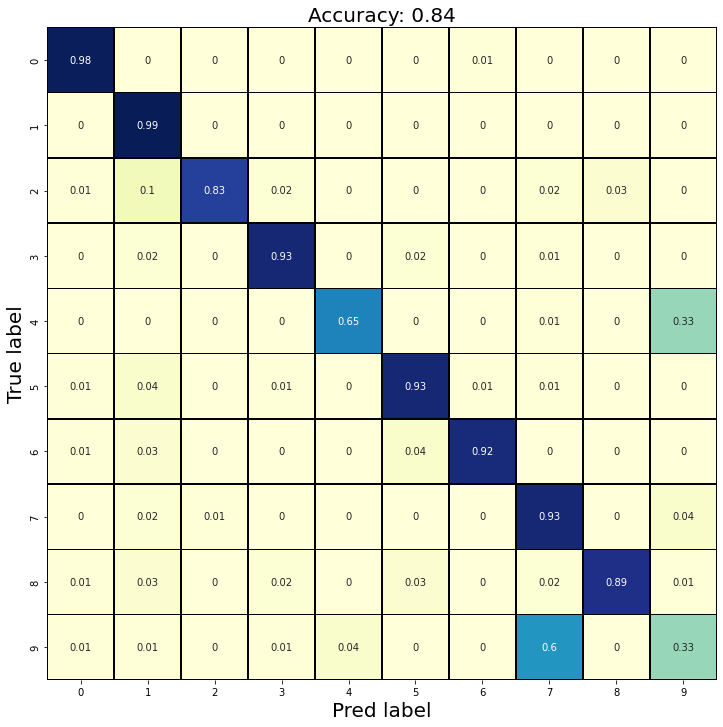

Pre-train Scheme Done!
Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 3s 6ms/step - loss: 34.9391
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 18.3032
Epoch 3/50
274/274 [==============================] - 2s 5ms/step - loss: 15.5601
Epoch 4/50
274/274 [==============================] - 2s 6ms/step - loss: 14.2589
Epoch 5/50
274/274 [==============================] - 2s 5ms/step - loss: 13.4347
Epoch 6/50
274/274 [==============================] - 1s 5ms/step - loss: 12.8156
Epoch 7/50
274/274 [==============================] - 2s 5ms/step - loss: 12.3323
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 11.9576
Epoch 9/50
274/274 [==============================] - 2s 8ms/step - loss: 11.6027
Epoch 10/50
274/274 [==============================] - 3s 9ms/step - loss: 11.3273
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 11.0974
Epoch 12/50
274/274 [==============================] - 2s 6ms/step - loss: 10.8410
Epoch 13/50
274/274 [===

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step
Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 cl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 6s 11ms/step - loss: 9.9210 - AE__loss: 8.4312 - clustering_loss: 1.4898
Training step: alpha[1]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 9.0811 - AE__loss: 8.2985 - clustering_loss: 0.7826
Training step: alpha[2]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.7807 - AE__loss: 8.1978 - clustering_loss: 0.5830
Training step: alpha[3]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.6102 - AE__loss: 8.1357 - clustering_loss: 0.4745
Training step: alpha[4]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.4699 - AE__loss: 8.0660 - clustering_loss: 0.4039
Training step: alpha[5]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.3793 - AE__loss: 8.0245 - clustering_loss: 0.3549
Training step: alpha[6]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.3069

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


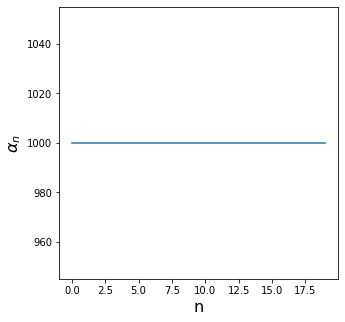

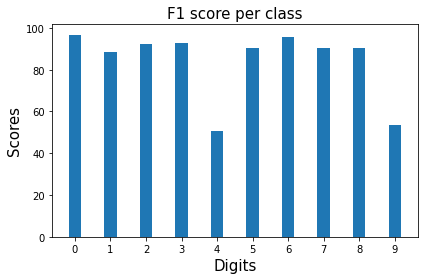

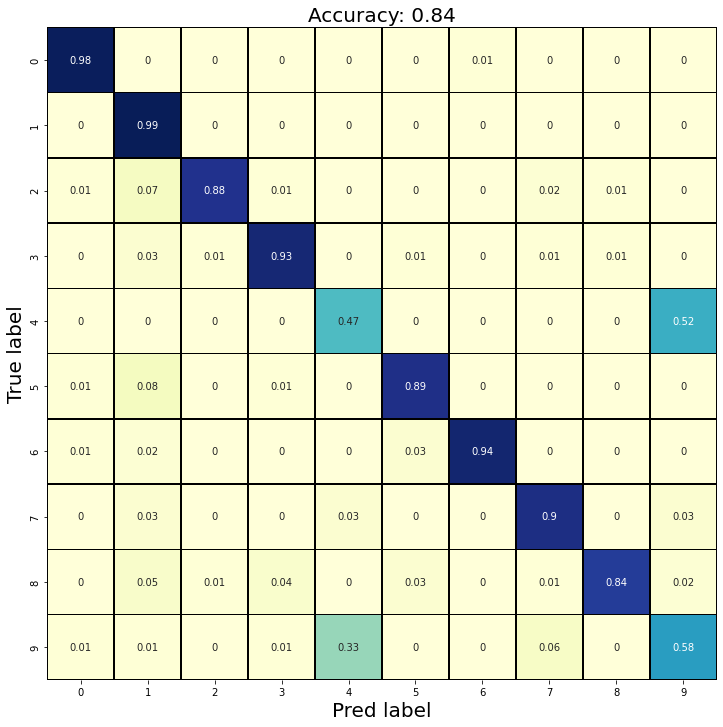

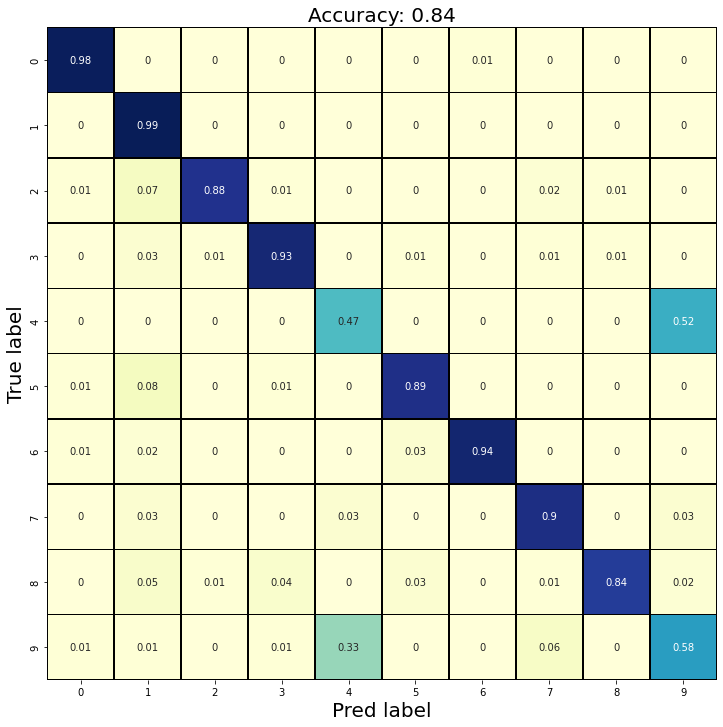

Pre-train Scheme Done!
Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 2s 6ms/step - loss: 28.2030
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 16.7589
Epoch 3/50
274/274 [==============================] - 2s 6ms/step - loss: 14.7968
Epoch 4/50
274/274 [==============================] - 2s 6ms/step - loss: 13.7130
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 12.9499
Epoch 6/50
274/274 [==============================] - 2s 6ms/step - loss: 12.3999
Epoch 7/50
274/274 [==============================] - 2s 6ms/step - loss: 11.9781
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 11.5899
Epoch 9/50
274/274 [==============================] - 2s 6ms/step - loss: 11.2965
Epoch 10/50
274/274 [==============================] - 2s 6ms/step - loss: 11.0024
Epoch 11/50
274/274 [==============================] - 2s 8ms/step - loss: 10.7995
Epoch 12/50
274/274 [==============================] - 3s 10ms/step - loss: 10.5581
Epoch 13/50
274/274 [==

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step
Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 cl

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


274/274 [==============================] - 6s 11ms/step - loss: 9.8392 - AE__loss: 8.3450 - clustering_loss: 1.4942
Training step: alpha[1]: 1000.0
1000.0
274/274 [==============================] - 3s 12ms/step - loss: 8.9954 - AE__loss: 8.2080 - clustering_loss: 0.7875
Training step: alpha[2]: 1000.0
1000.0
274/274 [==============================] - 3s 11ms/step - loss: 8.6794 - AE__loss: 8.0927 - clustering_loss: 0.5867
Training step: alpha[3]: 1000.0
1000.0
274/274 [==============================] - 3s 12ms/step - loss: 8.4655 - AE__loss: 7.9906 - clustering_loss: 0.4749
Training step: alpha[4]: 1000.0
1000.0
274/274 [==============================] - 3s 12ms/step - loss: 8.3682 - AE__loss: 7.9655 - clustering_loss: 0.4027
Training step: alpha[5]: 1000.0
1000.0
274/274 [==============================] - 3s 12ms/step - loss: 8.2798 - AE__loss: 7.9274 - clustering_loss: 0.3523
Training step: alpha[6]: 1000.0
1000.0
274/274 [==============================] - 3s 12ms/step - loss: 8.1800

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


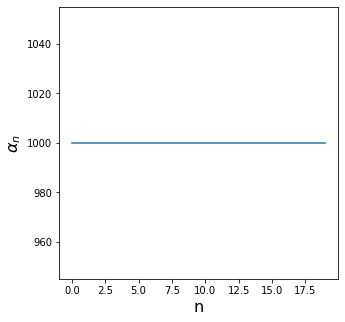

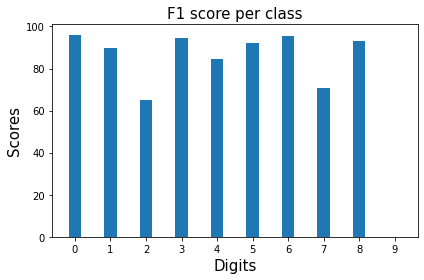

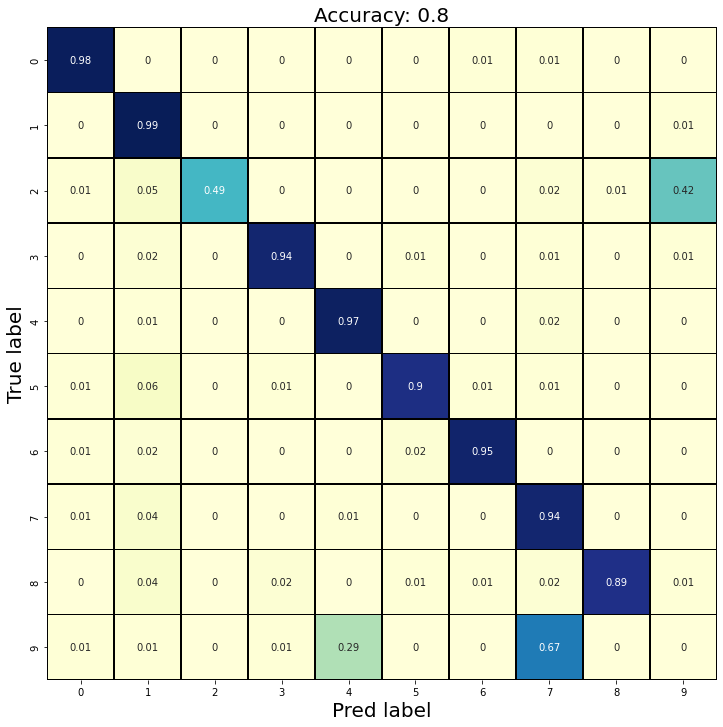

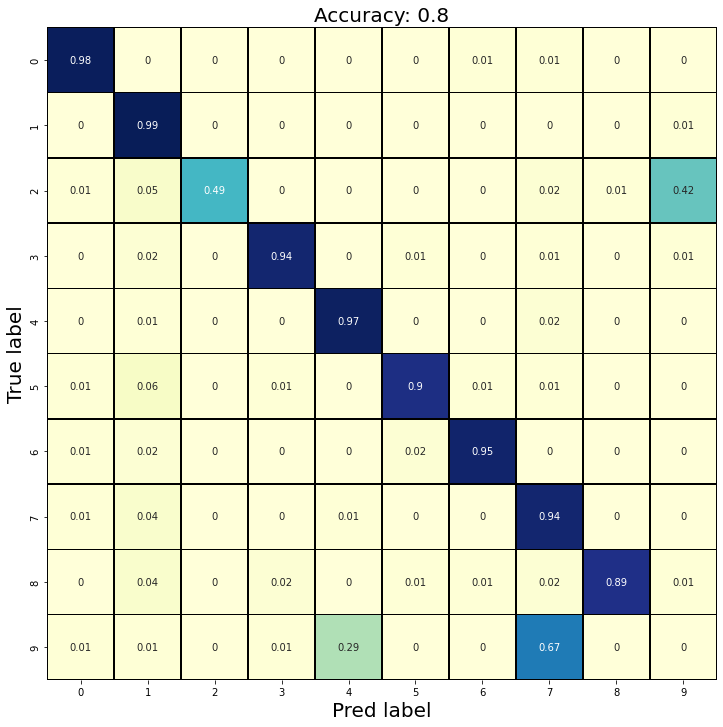

In [ ]:
#pretrained
alphas = [3,30,150,300]
for i in range(5,9):
  acc, f1score, cm = run(x=x,y=y,Pre_train = True, alpha_zero=alphas[i-5])
  results.loc[i,:] = [alphas[i-5],0, acc] + list(f1score) 

### Testando as variações do modelo

Começamos testando o modelo para as duas variações e diferentes configurações do parâmetro, como proposto. Os resultados estão apresentados na tabela a seguir:

In [ ]:
results.replace(0,"-")

,alpha-pretrained,alpha-annealing,accuracy,f1(1),f1(2),f1(3),f1(4),f1(5),f1(6),f1(7),f1(8),f1(9),f1(10)
1,-,0.01,0.83376,96.836255,87.841808,88.562738,90.608113,70.740712,90.317776,94.732949,77.941437,88.798589,42.665357
2,-,0.1,0.72243,67.350259,85.907145,90.202106,85.095057,78.982104,79.713186,-,72.674511,89.016432,-
3,-,0.5,0.76319,94.466572,75.694536,88.501905,84.260084,72.765213,74.124335,91.137905,79.467817,85.122616,1.528283
4,-,1,0.81036,93.189606,83.577149,88.892282,89.902992,73.973080,87.267792,91.528956,78.593732,85.937256,-
5,3,-,0.84813,97.518646,89.945746,93.250260,93.698860,50.970625,90.679202,96.658098,93.633989,90.812831,50.132569
6,30,-,0.83793,96.924404,89.527415,89.837746,93.822257,76.419966,91.232727,94.260948,72.121180,91.921414,38.507338
7,150,-,0.84279,96.845426,88.585355,92.254370,92.929856,50.649968,90.413821,95.864829,90.497116,90.342337,53.65821
8,300,-,0.80451,96.162882,89.621447,65.017195,94.371071,84.483201,92.111463,95.523482,70.776373,93.194765,-


### Conclusões

Discutiremos agora cada um dos testes realizados. Começamos pelos testes com esquema annealing.

O melhor modelo desta versão é o que utiliza menor alfa, ou seja, incrementa alfa mais lentamente, com alfa 0.01. Neste caso, além da maior acurácia, a performace é, em geral, melhor em cada uma das classes. Ao incrementar o alfa mais lentamente, mais iterações usam alfas próximos de 0. Ou seja, mais iterações removem a influência de G no cálculo da loss, causando, para esse dataset e *inicialização* um resultado melhor

Como um todo, todas as versões testadas tem mais dificuldade em classificar pontos da última classe (dígito 9), como podemos ver pelo score f1. Este esquema de annealing (alfa incial igual a 0) é o que performa melhor para esta classe, enquanto mantém um f1 score muito próximo ou mais alto que os  demais deste esquema.

Os demais 0.1 e 0.5 têm o pior resultado. Quando alfa é mais próximo de 0 o comportamento comentado anteriormente é esperado. Mas, conforme se aproxima de 1, a influência de G é adicionada no modelo e acontece o soft assigment, em que a representação é atribuida a classe cujo centroide esta mais próximo, porém ainda há algum *peso* para as demais classes. Já para o caso em que já começamos em 1, os resultados são melhores, performando soft assigment desde o início - porém observe que este modelo não consegue classificar a última classe. 

Os modelos pré-treinados performam melhor (assim como nos resultados do paper do modelo), perfomando diretamente o k-means no espaço latente, em que o k-mean é aprendido conjuntamente com o processo de agrupamento (representações do espaço latente). 


Podemos ver que o valor do alfa constante influência bastante para classes específicas. Por exemplo, o modelo com alfa constante 300 é o que tem menor f1 em geral, porém para a classe 5, em que os demais são ruins (f1 médio em entre 50-70) ele performa bem melhor (f1 de 84), mas não consegue prever a última classe também. Os melhores modelo deste esquema são os que usam alfa 3 e 150, que possuem resultados bem próximos. Ambos tem constância dos resultados nas classes - tendo uma menor performace nas classes 5 (digito 4) e 10 (digito 9). Essa má performace acontece pois, pelos heatmaps a classe 10 é confundida na classificação com a 5 - diminuindo o score de ambas as classes. Sabemos que os digítos 4 e 9 são facilmente confundíveis, dependendo da forma com que são escitos - e o modelo não captura essas diferenças muito bem.

### Testando o melhor modelo

Usando a acurácia para comparar os modelos, o melhor dentre os testados acima é o Pre trained com alpha constante igual a 3. Então, para este modelo iremos variar o número de clusteres a ser encontrado pelo modelo e avaliar como ele performa:

Pre-train Scheme Done!
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None, 

<ipython-input-11-109756b98597>:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs = num_epochs_AE)


Epoch 1/50
274/274 [==============================] - 5s 5ms/step - loss: 27.6599
Epoch 2/50
274/274 [==============================] - 1s 5ms/step - loss: 16.7706
Epoch 3/50
274/274 [==============================] - 1s 5ms/step - loss: 14.7430
Epoch 4/50
274/274 [==============================] - 2s 9ms/step - loss: 13.6514
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 12.8983
Epoch 6/50
274/274 [==============================] - 1s 5ms/step - loss: 12.3492
Epoch 7/50
274/274 [==============================] - 1s 5ms/step - loss: 11.9026
Epoch 8/50
274/274 [==============================] - 1s 5ms/step - loss: 11.5483
Epoch 9/50
274/274 [==============================] - 1s 5ms/step - loss: 11.2192
Epoch 10/50
274/274 [==============================] - 1s 5ms/step - loss: 10.9459
Epoch 11/50
274/274 [==============================] - 1s 5ms/step - loss: 10.7069
Epoch 12/50
274/274 [==============================] - 1s 5ms/step - loss: 10.4880
Epoch 13/50
2

<ipython-input-11-109756b98597>:64: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 2ms/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 2)                 20        
                                                                 
 clu

<ipython-input-11-109756b98597>:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs = num_epochs_per_alpha)


274/274 [==============================] - 3s 7ms/step - loss: 10.2179 - AE__loss: 8.5809 - clustering_loss: 1.6371
Training step: alpha[1]: 1000.0
1000.0
274/274 [==============================] - 2s 7ms/step - loss: 9.0606 - AE__loss: 8.2997 - clustering_loss: 0.7609
Training step: alpha[2]: 1000.0
1000.0
274/274 [==============================] - 2s 7ms/step - loss: 8.7239 - AE__loss: 8.1517 - clustering_loss: 0.5722
Training step: alpha[3]: 1000.0
1000.0
274/274 [==============================] - 2s 7ms/step - loss: 8.4884 - AE__loss: 8.0168 - clustering_loss: 0.4716
Training step: alpha[4]: 1000.0
1000.0
274/274 [==============================] - 2s 7ms/step - loss: 8.3598 - AE__loss: 7.9545 - clustering_loss: 0.4054
Training step: alpha[5]: 1000.0
1000.0
274/274 [==============================] - 2s 7ms/step - loss: 8.2675 - AE__loss: 7.9085 - clustering_loss: 0.3590
Training step: alpha[6]: 1000.0
1000.0
274/274 [==============================] - 2s 7ms/step - loss: 8.1726 - AE_

<ipython-input-11-109756b98597>:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/utils/linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


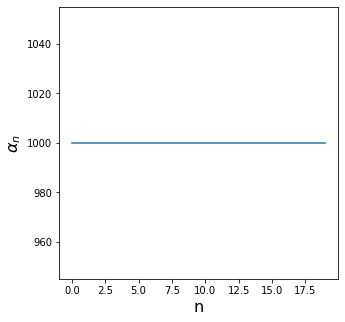

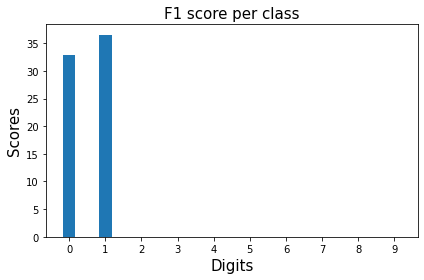

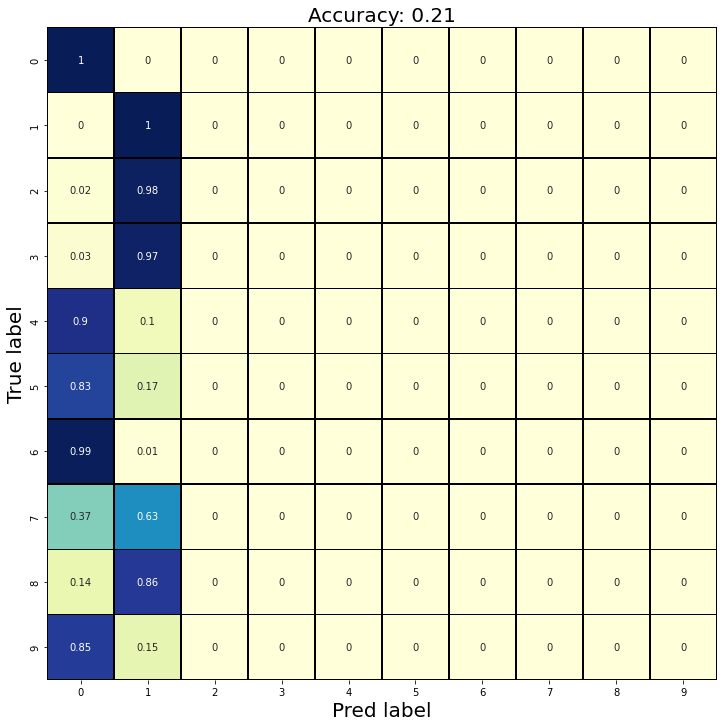

Pre-train Scheme Done!
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None, 

<ipython-input-11-109756b98597>:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs = num_epochs_AE)


274/274 [==============================] - 2s 5ms/step - loss: 31.2959
Epoch 2/50
274/274 [==============================] - 1s 5ms/step - loss: 17.2941
Epoch 3/50
274/274 [==============================] - 1s 5ms/step - loss: 15.0837
Epoch 4/50
274/274 [==============================] - 1s 5ms/step - loss: 13.8965
Epoch 5/50
274/274 [==============================] - 1s 5ms/step - loss: 13.1059
Epoch 6/50
274/274 [==============================] - 1s 5ms/step - loss: 12.5508
Epoch 7/50
274/274 [==============================] - 1s 5ms/step - loss: 12.0924
Epoch 8/50
274/274 [==============================] - 1s 5ms/step - loss: 11.6996
Epoch 9/50
274/274 [==============================] - 1s 5ms/step - loss: 11.4090
Epoch 10/50
274/274 [==============================] - 1s 5ms/step - loss: 11.1027
Epoch 11/50
274/274 [==============================] - 1s 5ms/step - loss: 10.8797
Epoch 12/50
274/274 [==============================] - 1s 5ms/step - loss: 10.6342
Epoch 13/50
274/274 [===

<ipython-input-11-109756b98597>:64: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 2ms/step
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 5)                 50        
                                                                 
 cl

<ipython-input-11-109756b98597>:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs = num_epochs_per_alpha)


274/274 [==============================] - 4s 8ms/step - loss: 10.0967 - AE__loss: 8.5257 - clustering_loss: 1.5710
Training step: alpha[1]: 1000.0
1000.0
274/274 [==============================] - 2s 8ms/step - loss: 9.0718 - AE__loss: 8.2920 - clustering_loss: 0.7798
Training step: alpha[2]: 1000.0
1000.0
274/274 [==============================] - 2s 8ms/step - loss: 8.7347 - AE__loss: 8.1539 - clustering_loss: 0.5808
Training step: alpha[3]: 1000.0
1000.0
274/274 [==============================] - 2s 8ms/step - loss: 8.5412 - AE__loss: 8.0674 - clustering_loss: 0.4737
Training step: alpha[4]: 1000.0
1000.0
274/274 [==============================] - 2s 8ms/step - loss: 8.4217 - AE__loss: 8.0169 - clustering_loss: 0.4048
Training step: alpha[5]: 1000.0
1000.0
274/274 [==============================] - 2s 8ms/step - loss: 8.3200 - AE__loss: 7.9629 - clustering_loss: 0.3572
Training step: alpha[6]: 1000.0
1000.0
274/274 [==============================] - 2s 8ms/step - loss: 8.2094 - AE_

<ipython-input-11-109756b98597>:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 4ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


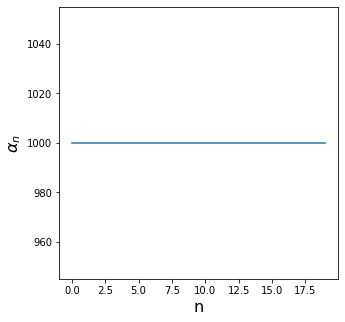

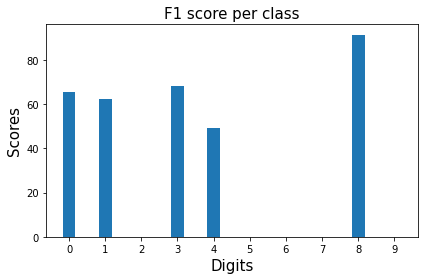

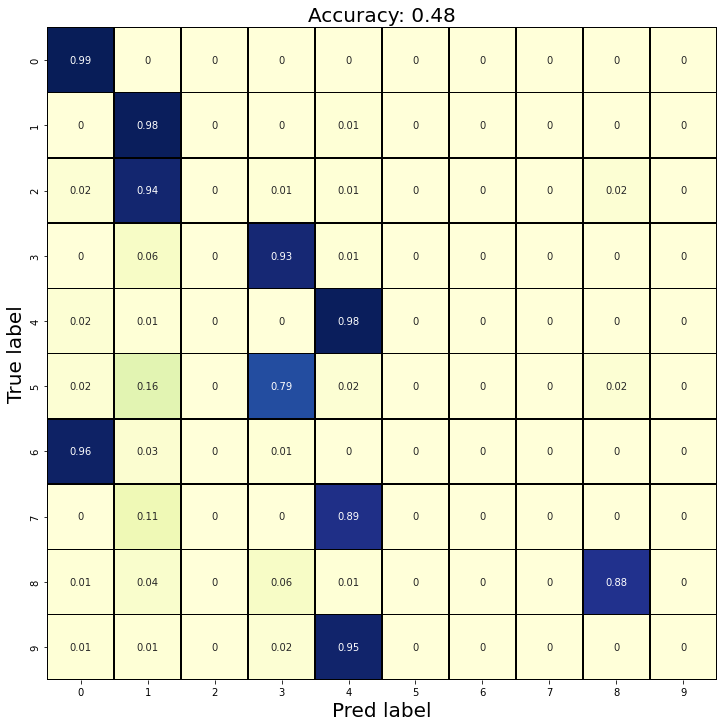

Pre-train Scheme Done!
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None,

<ipython-input-11-109756b98597>:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs = num_epochs_AE)


274/274 [==============================] - 3s 7ms/step - loss: 29.5999
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 17.0162
Epoch 3/50
274/274 [==============================] - 2s 6ms/step - loss: 14.9844
Epoch 4/50
274/274 [==============================] - 2s 7ms/step - loss: 13.8648
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 13.1318
Epoch 6/50
274/274 [==============================] - 2s 6ms/step - loss: 12.5724
Epoch 7/50
274/274 [==============================] - 2s 6ms/step - loss: 12.1094
Epoch 8/50
274/274 [==============================] - 2s 8ms/step - loss: 11.7695
Epoch 9/50
274/274 [==============================] - 2s 8ms/step - loss: 11.4450
Epoch 10/50
274/274 [==============================] - 2s 7ms/step - loss: 11.1799
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 10.9390
Epoch 12/50
274/274 [==============================] - 2s 6ms/step - loss: 10.7331
Epoch 13/50
274/274 [===

<ipython-input-11-109756b98597>:64: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 2ms/step
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 10)                100       
                                                                 
 cl

<ipython-input-11-109756b98597>:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs = num_epochs_per_alpha)


274/274 [==============================] - 5s 10ms/step - loss: 9.8177 - AE__loss: 8.3783 - clustering_loss: 1.4395
Training step: alpha[1]: 1000.0
1000.0
274/274 [==============================] - 3s 10ms/step - loss: 8.9847 - AE__loss: 8.2259 - clustering_loss: 0.7588
Training step: alpha[2]: 1000.0
1000.0
274/274 [==============================] - 3s 10ms/step - loss: 8.7066 - AE__loss: 8.1399 - clustering_loss: 0.5667
Training step: alpha[3]: 1000.0
1000.0
274/274 [==============================] - 3s 10ms/step - loss: 8.5367 - AE__loss: 8.0762 - clustering_loss: 0.4604
Training step: alpha[4]: 1000.0
1000.0
274/274 [==============================] - 3s 10ms/step - loss: 8.3953 - AE__loss: 8.0027 - clustering_loss: 0.3926
Training step: alpha[5]: 1000.0
1000.0
274/274 [==============================] - 3s 10ms/step - loss: 8.2989 - AE__loss: 7.9559 - clustering_loss: 0.3430
Training step: alpha[6]: 1000.0
1000.0
274/274 [==============================] - 4s 14ms/step - loss: 8.2377

<ipython-input-11-109756b98597>:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step


/usr/local/lib/python3.8/dist-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


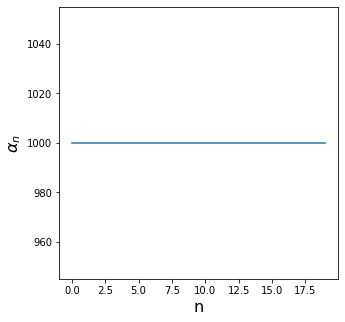

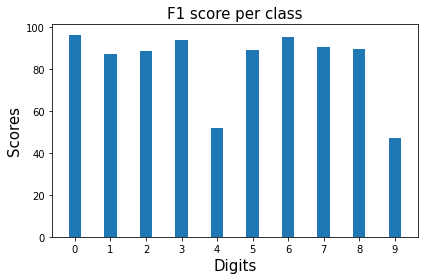

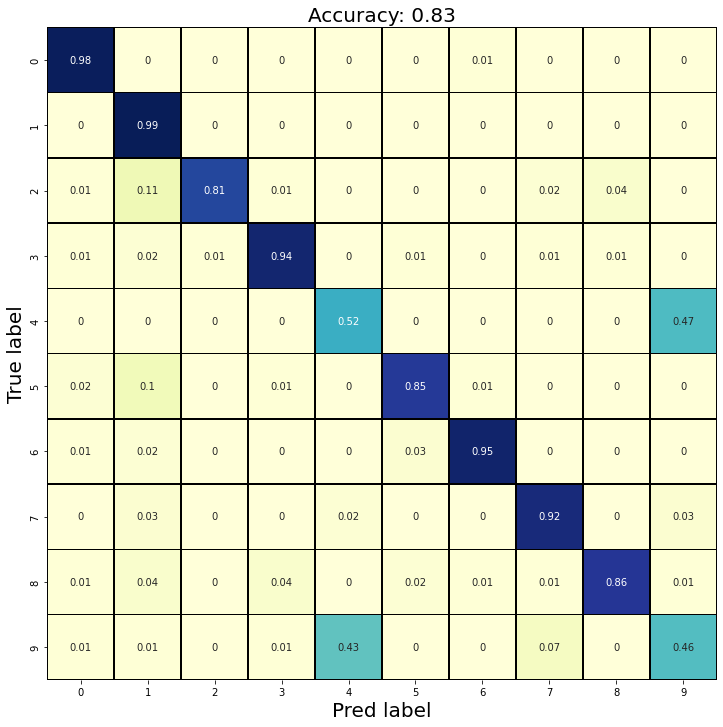

Pre-train Scheme Done!
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 decoder_3 (Dense)           (None, 2000)              22000     
                                                                 
 decoder_2 (Dense)           (None,

<ipython-input-11-109756b98597>:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = autoencoder.fit_generator(generator=training_generator, epochs = num_epochs_AE)


274/274 [==============================] - 2s 7ms/step - loss: 29.2023
Epoch 2/50
274/274 [==============================] - 2s 6ms/step - loss: 16.8747
Epoch 3/50
274/274 [==============================] - 2s 6ms/step - loss: 14.7568
Epoch 4/50
274/274 [==============================] - 2s 6ms/step - loss: 13.6370
Epoch 5/50
274/274 [==============================] - 2s 6ms/step - loss: 12.8924
Epoch 6/50
274/274 [==============================] - 2s 6ms/step - loss: 12.3353
Epoch 7/50
274/274 [==============================] - 2s 6ms/step - loss: 11.9084
Epoch 8/50
274/274 [==============================] - 2s 6ms/step - loss: 11.5180
Epoch 9/50
274/274 [==============================] - 2s 7ms/step - loss: 11.2171
Epoch 10/50
274/274 [==============================] - 2s 6ms/step - loss: 10.9502
Epoch 11/50
274/274 [==============================] - 2s 6ms/step - loss: 10.7172
Epoch 12/50
274/274 [==============================] - 2s 6ms/step - loss: 10.5269
Epoch 13/50
274/274 [===

<ipython-input-11-109756b98597>:64: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_features = encoder.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 4ms/step
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 encoder_0 (Dense)           (None, 500)               392500    
                                                                 
 encoder_1 (Dense)           (None, 500)               250500    
                                                                 
 encoder_2 (Dense)           (None, 2000)              1002000   
                                                                 
 encoder_3 (Dense)           (None, 10)                20010     
                                                                 
 distance (DistanceLayer)    (None, 20)                200       
                                                                 
 cl

<ipython-input-11-109756b98597>:91: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = Deep_km.fit_generator(generator=deep_kmeans_gen, epochs = num_epochs_per_alpha)


274/274 [==============================] - 11s 17ms/step - loss: 9.6584 - AE__loss: 8.2401 - clustering_loss: 1.4183
Training step: alpha[1]: 1000.0
1000.0
274/274 [==============================] - 5s 19ms/step - loss: 8.9023 - AE__loss: 8.1267 - clustering_loss: 0.7755
Training step: alpha[2]: 1000.0
1000.0
274/274 [==============================] - 4s 13ms/step - loss: 8.5844 - AE__loss: 8.0075 - clustering_loss: 0.5769
Training step: alpha[3]: 1000.0
1000.0
274/274 [==============================] - 4s 13ms/step - loss: 8.4204 - AE__loss: 7.9525 - clustering_loss: 0.4680
Training step: alpha[4]: 1000.0
1000.0
274/274 [==============================] - 4s 13ms/step - loss: 8.3136 - AE__loss: 7.9174 - clustering_loss: 0.3962
Training step: alpha[5]: 1000.0
1000.0
274/274 [==============================] - 4s 13ms/step - loss: 8.2083 - AE__loss: 7.8627 - clustering_loss: 0.3456
Training step: alpha[6]: 1000.0
1000.0
274/274 [==============================] - 4s 13ms/step - loss: 8.136

<ipython-input-11-109756b98597>:95: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  extract_feat = Deep_km_predictor.predict_generator(AE_generator, verbose=1)


274/274 [==============================] - 1s 3ms/step
Error plotting 1 scores bars


/usr/local/lib/python3.8/dist-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


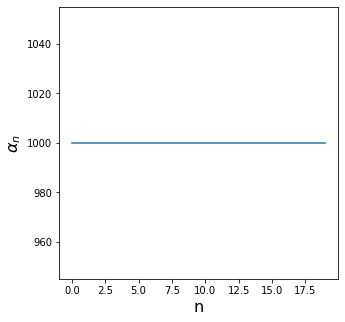

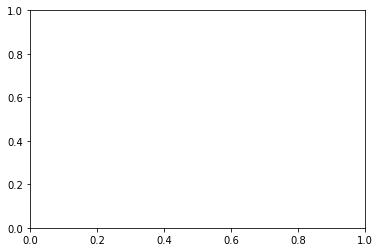

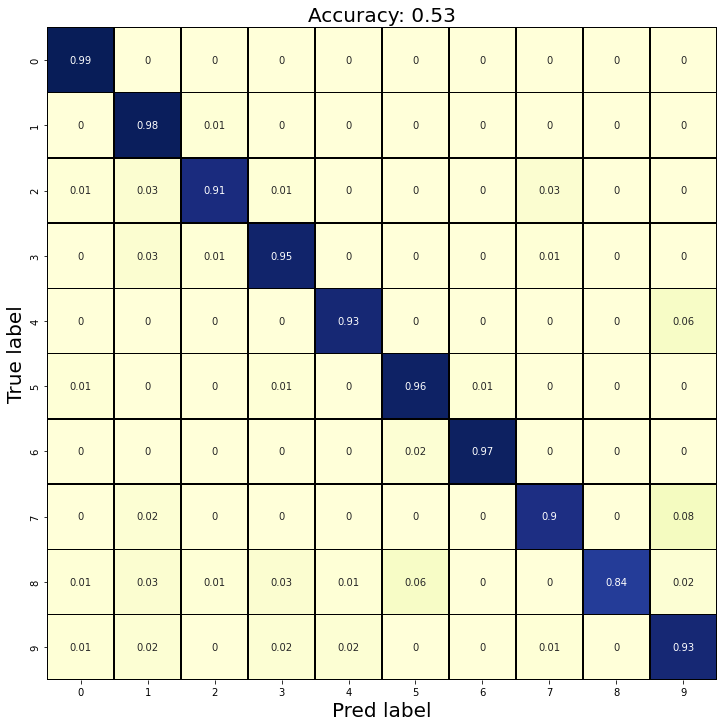

In [12]:
results2 = pd.DataFrame(columns=['accuracy','f1(1)','f1(2)','f1(3)','f1(4)','f1(5)','f1(6)','f1(7)','f1(8)','f1(9)','f1(10)','f1(11)','f1(12)','f1(13)','f1(14)','f1(15)','f1(16)','f1(17)','f1(18)','f1(19)','f1(20)'], index = [2, 5, 10,20])
for i in results2.index:
  acc, f1score, cm = run(x=x,y=y,Pre_train = True,  constant_alpha=3,n_clusters = i)
  col_to_use = results2.columns[:1+len(f1score)]
  results2.loc[i,col_to_use] = [acc] + list(f1score) 


In [16]:
results2.replace(0,np.nan).dropna(axis=1,how='all')

,accuracy,f1(1),f1(2),f1(3),f1(4),f1(5),f1(6),f1(7),f1(8),f1(9),f1(10)
2,0.21054,32.919551,36.572628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.48437,65.474711,62.133045,NaN,68.157341,49.207229,NaN,NaN,NaN,91.399406,NaN
10,0.82997,96.374019,87.066035,88.540278,93.576571,51.999414,89.184500,95.336560,90.337838,89.245096,47.002118
20,0.53327,54.116185,68.250371,65.230944,93.375713,66.474211,64.622593,71.765573,64.754541,60.128323,61.476535


### Conclusão

Nos modelos em qe tentamos encontrar menos classes do que o real (10), o modelo, obviamente, performa mal para as classes que faltam: observe que classifica corretamente as classes existentes quase 100% das vezes, enquanto as demais são classificadas com base em alguma característica que a representação no espaço latente possui, tal que as classes fiquem mais próximas uma da outra. Olhando os heatmaps acima, que mostra como o modelo classifica as imagens, essa similaridade não é obvia. 

Para o modelo com 10 classes, temos o mesmo resultado obtido anteriormente. 

O interessante é comparar com os resultados em que usamos 20 classes - o dobro do valor real. Neste caso, o modelo acaba errando ao tentar separar mais que o necessário - e ao fazer isso não generaliza bem. Nas imagens abaixo conseguimos ter uma intuição do que ocorre; o modelo acaba separando imagens da mesma classe mas que possuem ruído de alguma forma - já que são digitos feitos à mão, esse ruído é esperado. 

As classes são distribuidas de forma balanceada no dataset:

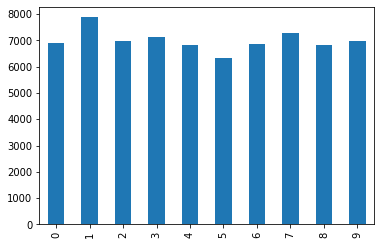

In [ ]:
pd.Series(y).value_counts().sort_index().plot.bar()

Para o modelo em que usamos k=20, o modelo utiliza ruído de certas imagens para fazer a separação dos clusters que não existem no *mundo real*, como demostrado pela imagem:

In [ ]:
y_pred_map = run(x=x,y=y,Pre_train = True,  constant_alpha=3,n_clusters = 20,preds=True)

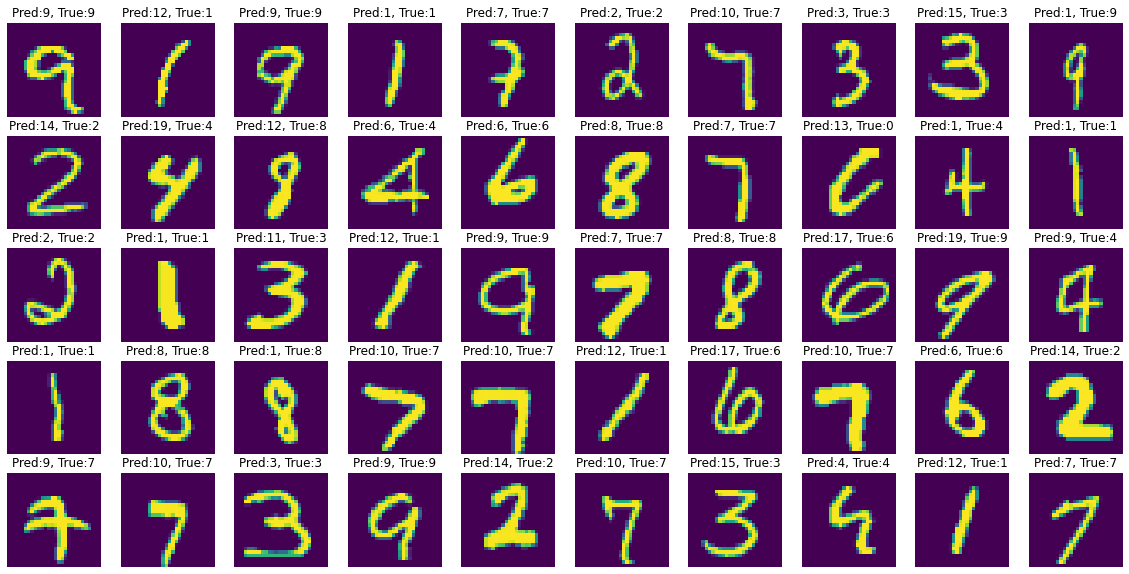

In [40]:
import random
fig, ax = plt.subplots(5,10,figsize=(20,10))

for i in range(5):
    for j in range(10):
        random_image = random.randint(0,y.shape[0])
        ax[i,j].imshow(x[random_image].reshape(28,-1))
        ax[i,j].set_title(f"Pred:{y_pred_map[random_image]}, True:{y[random_image]}")
        ax[i,j].axis("off")

plt.show()

A figura acima ilustra muito bem o ponto comentado, a respeito do modelo em que temos 20 clusters. Perceba, por exemplo, as imagens em que o dígito correto é o 1. Quando a escrita está mais na diagonal, no geral, o modelo classifica no cluster 12, já quando o desenho é mais reto, ele acerta na classe 1. Outros exemplos podem ser retirados da imagem acima, por exemplo, o número 2 quando escrito com o sem fazer uma curva na parte inferior (sem a curva, é classificado na classe 14, com na classe correta 2).